In [33]:
%reset -f

In [34]:
#Calling all the required libraries:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import pickle

In [35]:
#Loading the dataset:
zomato_data_nw = pd.read_csv("./data/zomato_df_final_data.csv")

In [36]:
# Checking for total NA values in the dataset
total_na_count = zomato_data_nw.isna().sum()

# Displaying the total NA values for each column
print(total_na_count)

address             0
cost              346
cuisine             0
lat               192
link                0
lng               192
phone               0
rating_number    3316
rating_text      3316
subzone             0
title               0
type               48
votes            3316
groupon             0
color               0
cost_2            346
cuisine_color       0
dtype: int64


In [37]:
# Checking for any empty cells (cells with empty strings) in the dataset
empty_cell = (zomato_data_nw == '').sum()

# Displaying the total empty cells for each column
print(empty_cell)

address          0
cost             0
cuisine          0
lat              0
link             0
lng              0
phone            0
rating_number    0
rating_text      0
subzone          0
title            0
type             0
votes            0
groupon          0
color            0
cost_2           0
cuisine_color    0
dtype: int64


In [38]:
# Since we will be making "rating_number as our target variable, lets remove the rows having NA or Null values for rating number.

# Removing the rows where 'rating_number' has NA or NaN values
zomato_new_cleaned = zomato_data_nw.dropna(subset=['rating_number', 'cost'])

# Rechecking the number of NA or NaN values in each column
na_count_nw = zomato_new_cleaned.isna().sum()

na_columns = na_count_nw[na_count_nw > 0]
print("Columns with missing values:")
print(na_columns)

Columns with missing values:
lat     112
lng     112
type     20
dtype: int64


In [39]:
# Adding a new column 'suburb' that extracts only the suburb names in the 'subzone' column
zomato_new_cleaned.loc[:, 'suburb'] = zomato_new_cleaned['subzone'].apply(lambda x: x.split(',')[-1].strip())

/var/folders/4t/5nz_d09553v4_cz4n9zxh9zh0000gn/T/ipykernel_8559/2511191916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zomato_new_cleaned.loc[:, 'suburb'] = zomato_new_cleaned['subzone'].apply(lambda x: x.split(',')[-1].strip())


In [40]:
# Selecting only numerical columns
numerical_columns = zomato_new_cleaned.select_dtypes(include=['float64', 'int64'])

# Calculating correlation between 'rating_number' and other numerical columns
correlation = numerical_columns.corr()['rating_number'].sort_values(ascending=False)

print("Top correlated features with 'rating_number':")
print(correlation)

Top correlated features with 'rating_number':
rating_number    1.000000
votes            0.535391
cost             0.231050
cost_2           0.231050
lng              0.011488
lat             -0.010093
Name: rating_number, dtype: float64


In [41]:
# Checking the data types of each column
column_types = zomato_new_cleaned.dtypes
print(column_types)

address           object
cost             float64
cuisine           object
lat              float64
link              object
lng              float64
phone             object
rating_number    float64
rating_text       object
subzone           object
title             object
type              object
votes            float64
groupon             bool
color             object
cost_2           float64
cuisine_color     object
suburb            object
dtype: object


#### Label/Feature Encoding:

#### Lets convert the non numeric columns using Label encoder to find out the correlation for all features.

In [42]:
# Using Label Encoding for non-numeric columns
from sklearn.preprocessing import LabelEncoder

# Selecting only the non-numeric columns
non_numeric_columns = zomato_new_cleaned.select_dtypes(include=['object']).columns

# Initializing LabelEncoder
lebel_encoder = LabelEncoder()

# Creating a copy of the dataframe to avoid modifying the original one
zomato_encoded = zomato_new_cleaned.copy()

# Applying Label Encoding for non-numeric columns
for col in non_numeric_columns:
    zomato_encoded[col] = zomato_encoded[col].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    zomato_encoded[col] = lebel_encoder.fit_transform(zomato_encoded[col].astype(str))

# Calculating the correlation matrix
correlation = zomato_encoded.corr()['rating_number'].sort_values(ascending=False)

print(correlation)


rating_number    1.000000
rating_text      0.629375
votes            0.535391
cost             0.231050
cost_2           0.231050
cuisine          0.025424
suburb           0.021929
lng              0.011488
subzone         -0.003308
groupon         -0.003444
lat             -0.010093
link            -0.015453
title           -0.018337
type            -0.046360
cuisine_color   -0.082713
address         -0.089345
phone           -0.091412
color           -1.000000
Name: rating_number, dtype: float64


#### From the output we can see, features having high correlation are: "rating_number", "rating_text", "votes ", "cost", "cost_2", "cuisine" and "suburb". Also, the "rating_text is same as the "rating_number", we have to exclude this during modelling. So we will be considering only the remaining highly correlated features for our modeling.

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

# Selecting only the specified features that determine our target variable.
selected_features = ['votes', 'cost', 'cost_2', 'cuisine', 'suburb']

# Preparing data with the selected features
X = zomato_encoded[selected_features]  # Use selected features
y = zomato_encoded['rating_number']

# Handling missing values if any, by filling with median of each column
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Spliting the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=0)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Linear Regression
linear_model_1 = LinearRegression()
linear_model_1.fit(X_train_scaled, y_train)

# Predicting and calculating MSE for model 1
y_pred_1 = linear_model_1.predict(X_test_scaled)
mse_model_1 = mean_squared_error(y_test, y_pred_1)

# Model 2: Linear Regression with Gradient Descent (SGDRegressor)
linear_model_2 = SGDRegressor(max_iter=1000, tol=1e-3, random_state=0)
linear_model_2.fit(X_train_scaled, y_train)

# Predicting and calculating MSE for model 2
y_pred_2 = linear_model_2.predict(X_test_scaled)
mse_model_2 = mean_squared_error(y_test, y_pred_2)

mse_model_1, mse_model_2

(0.16701766881520794, 0.17579263773803885)

In [44]:
# Lets calculate r-squared and rmse for futher analysis and insight about model accuracy.

from sklearn.metrics import r2_score
import numpy as np

# Linear Regression
linear_model_1 = LinearRegression()
linear_model_1.fit(X_train_scaled, y_train)

# Predicting and calculating MSE for model 1
y_pred_1 = linear_model_1.predict(X_test_scaled)
rmse_model_1 = np.sqrt(mse_model_1)  # Calculate RMSE
r2_model_1 = r2_score(y_test, y_pred_1)  # Calculate R-squared

# Linear Regression with Gradient Descent (SGDRegressor)
linear_model_2 = SGDRegressor(max_iter=1000, tol=1e-3, random_state=0)
linear_model_2.fit(X_train_scaled, y_train)

# Predicting and calculating MSE for model 2
y_pred_2 = linear_model_2.predict(X_test_scaled)
rmse_model_2 = np.sqrt(mse_model_2)  # Calculate RMSE
r2_model_2 = r2_score(y_test, y_pred_2)  # Calculate R-squared

#Display the results:
print("rmse for linear model 1: ", rmse_model_1)
print("r-squared for linear model 1: ", r2_model_1)

print("rmse for linear model 2: ", rmse_model_2)
print("r-squared for linear model 2: ", r2_model_2)


rmse for linear model 1:  0.40867795244569766
r-squared for linear model 1:  0.21889054776244088
rmse for linear model 2:  0.4192763262313278
r-squared for linear model 2:  0.17785170907347725


##### From the output we can see, MSE for model 1 is approx. 0.167 and MSE for model 2 is approx. 0.176.
##### Both models gave good predictive accuracy with low MSE values ((0.167 vs. 0.176)). And, the minimal difference between the results of two models suggests that the dataset and the selected features are good enough for linear modeling.

### III 7. Build a logistic regression model (model_classification_3) for the simplified data, with 80% training data and 20% test data.

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Binary Classes: ***Class 1: 'Poor' and 'Average'*** and, *** Class 2: 'Good', 'Very Good', 'Excellent' ***

#Creating a copy
zomato_binary = zomato_new_cleaned.copy()

#Performing the binary classification
zomato_binary['rating_class'] = zomato_binary['rating_text'].map({
    'Poor': 1,
    'Average': 1,
    'Good': 2,
    'Very Good': 2,
    'Excellent': 2
})

# Using Label Encoding for non-numeric columns
from sklearn.preprocessing import LabelEncoder

# Initializing LabelEncoder
lebel_encoder = LabelEncoder()

# Creating a copy of the dataframe
zomato_binary_encoded = zomato_binary.copy()

# Applying Label Encoding for non-numeric columns
for col in non_numeric_columns:
    zomato_binary_encoded[col] = zomato_binary_encoded[col].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    zomato_binary_encoded[col] = lebel_encoder.fit_transform(zomato_binary_encoded[col].astype(str))

# Selecting only the most relevant features
selected_features = ['votes', 'cost', 'cost_2', 'cuisine', 'suburb']

# Preparing data with the selected features
X = zomato_binary_encoded[selected_features]  # Use selected features
y = zomato_binary_encoded['rating_class']

# Spliting the dataset into training - 80% and testing - 20% sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Building the Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Predictions
y_pred = logistic_model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Confusion Matrix:
 [[862  79]
 [155 321]]
Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.92      0.88       941
           2       0.80      0.67      0.73       476

    accuracy                           0.83      1417
   macro avg       0.83      0.80      0.81      1417
weighted avg       0.83      0.83      0.83      1417



### III 8. Use the confusion matrix to report the results of using the classification model on the test data.

Confusion Matrix:
 [[862  79]
 [155 321]]


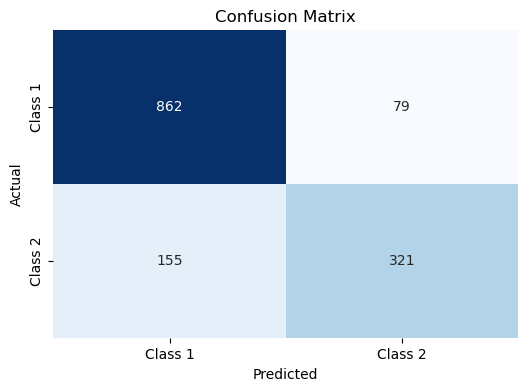

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Displaying the Confusion Matrix for Logistic Regression
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Class 1', 'Class 2'], yticklabels=['Class 1', 'Class 2'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### III 9. Draw your conclusions and observations about the performance of the model relevant to the classes’ distributions.


#### From the Confusion Matrix we can understand the following;
#### Class 1 (Ratings: Poor/Average): True Positives: 862 (predicted correctly as Class 1), False Positive: 79 (predicted incorrectly as Class 1 but are actually Class 2).
#### Class 2 (Ratings: Good/Very Good/Excellent): True Negatives: 321 (predicted correctly as Class 2), False Negatives: 155 (predicted incorrectly as Class 2 but are actually Class 1).
#### This signifies that our model perfermes well in predicting the Class 1 ratings, whereas it is not very effective for predicting the Class 2 ratings. 
#### This imbalance is may be due the difference in sample size of class 1 ratings(941) and class 2 ratings(476).

#### Also, from the classification report, we can understand the following;
#### Class 1: Precision: 85% , Recall: 92% ; Successfully predicted and identified Class 1 samples.
#### Class 2: Precision: 80% , Recall: 67% ; The model only correctly identified 67% of actual Class 2 samples, so it is missing 33% of these cases.
#### So, the conclusion, that we have drawn earlier, from the Confusion matrix, is backed up by this as well.

### III 10. Repeat the previous classification task using three other models of your choice and report the performance.

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Selecting only the most relevant features
selected_features = ['votes', 'cost', 'cost_2', 'cuisine', 'suburb']

# Preparing data with the selected features
X = zomato_binary_encoded[selected_features]  # Use selected features
y = zomato_binary_encoded['rating_class']

# Spliting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Model 1: Random Forest Classifier
randomforest_model = RandomForestClassifier(random_state=0)
randomforest_model.fit(X_train, y_train)

# Model 2: Support Vector Classifier (SVC)
svc_model = SVC(random_state=0)
svc_model.fit(X_train, y_train)

# Model 3: K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Predictions for each model
y_pred_randomforest = randomforest_model.predict(X_test)
y_pred_svc = svc_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

# Evaluation of Random Forest Classifier
print("Random Forest Classifier Performance")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_randomforest))
print("Classification Report:\n", classification_report(y_test, y_pred_randomforest))

# Evaluation of Support Vector Classifier (SVC)
print("\nSupport Vector Classifier Performance")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))
print("Classification Report:\n", classification_report(y_test, y_pred_svc))

# Evaluation of K-Nearest Neighbors (KNN)
print("\nK-Nearest Neighbors Performance")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))


Random Forest Classifier Performance
Confusion Matrix:
 [[818 123]
 [ 93 383]]
Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.87      0.88       941
           2       0.76      0.80      0.78       476

    accuracy                           0.85      1417
   macro avg       0.83      0.84      0.83      1417
weighted avg       0.85      0.85      0.85      1417


Support Vector Classifier Performance
Confusion Matrix:
 [[863  78]
 [153 323]]
Classification Report:
               precision    recall  f1-score   support

           1       0.85      0.92      0.88       941
           2       0.81      0.68      0.74       476

    accuracy                           0.84      1417
   macro avg       0.83      0.80      0.81      1417
weighted avg       0.83      0.84      0.83      1417


K-Nearest Neighbors Performance
Confusion Matrix:
 [[824 117]
 [110 366]]
Classification Report:
               precision    recall  f1-s

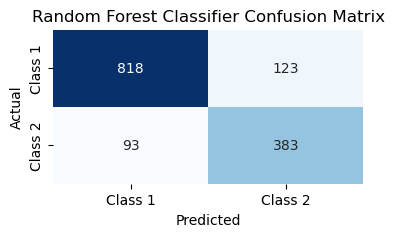

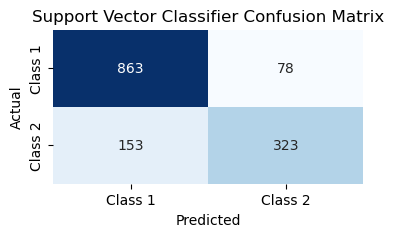

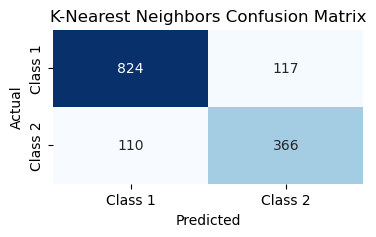

In [48]:
#Plotting the confusion matrix for visualisation:

# Plotting function for confusion matrices
def plot_confusion_matrix(model_name, y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 2))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=['Class 1', 'Class 2'], yticklabels=['Class 1', 'Class 2'])
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

# Plot confusion matrix for Random Forest Classifier
plot_confusion_matrix("Random Forest Classifier", y_test, y_pred_randomforest)

# Plot confusion matrix for Support Vector Classifier (SVC)
plot_confusion_matrix("Support Vector Classifier", y_test, y_pred_svc)

# Plot confusion matrix for K-Nearest Neighbors (KNN)
plot_confusion_matrix("K-Nearest Neighbors", y_test, y_pred_knn)


#### Conclusions:
#### Best Model for Class 1 (Poor/Average): SVC showed best performance in identifying Class 1, with the highest recallof 92%, which suggests, it correctly identifies more low-rated restaurants than the other models. In other hand, Random Forest and KNN shows strong performance for Class 1, evenly balancing the precision and recall.
#### Best Model for Class 2 (Good/Very Good/Excellent): Random Forest showed best performance for Class 2, with a recall of 92% and precision of 72% , suggesting better balance between true positives and false negatives for high-rated restaurants. Additionally, KNN also provides balanced performance for Class 2, with a recall of 77%.
#### Overall Best Model: Random Forest had the best overall performance with the highest accuracy of 85%, balancing both classes, and had good F1-score. Having the best combination of precision and recall, it can be considered better choice for this classification problem. Furthermore, SVC gave strong results for precision for Class 1, but had lower recall for Class 2, suggesting bias in correctly predicting low-rated restaurants while struggling with higher-rated ones. And, KNN provided balanced results, but slightly lower performance compared to Random Forest.
#### In conclusion, Random Forest seemed to be the most suitable model in tgis case of binary classification task, which offered the best balance between precision and recall, particularly for Class 2, making it effective for detecting high-rated restaurants as well.
